In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import scale, normalize


In [4]:
normalization = True
def normalize_features(X, lpc_max_order):
    norm_X = np.zeros(X.shape)
    n_features = X.shape[1]
    n_skip = n_features // lpc_max_order
    for f in np.arange(n_features):
        norm_X[:, f::n_skip] = normalize(X[:, f::n_skip], axis=1)
    return norm_X

### Extract train features

In [7]:
train_algs = ['-','A01', 'A02', 'A03', 'A04', 'A05', 'A06']


max_lpc_order = 50
lpc_lengths = np.arange(1, max_lpc_order + 1)

train_alg = {}

gain_log_scale = True
for alg in train_algs:
    X_train_list = []
    for l in lpc_lengths:
        train_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/lpc/train_LPC_' + str(l) +'.pkl')
        #train_features.drop('coeff', axis=1, inplace=True)
        train_features = train_features[(train_features['system_id']==alg)]
        train_features.dropna(inplace=True)

        X_train_list.append(np.array(train_features['lpc_res_mean']).reshape((-1, 1)))
        X_train_list.append(np.array(train_features['lpc_res_max']).reshape((-1, 1)))
        X_train_list.append(np.array(train_features['lpc_res_min']).reshape((-1, 1)))
        X_train_list.append(np.array(train_features['lpc_res_var']).reshape((-1, 1)))
        
        if gain_log_scale == False:
            X_train_list.append(np.array(train_features['lpc_gain_max']).reshape((-1, 1)))
            X_train_list.append(np.array(train_features['lpc_gain_min']).reshape((-1, 1)))
            X_train_list.append(np.array(train_features['lpc_gain_mean']).reshape((-1, 1)))
            X_train_list.append(np.array(train_features['lpc_gain_var']).reshape((-1, 1)))
        else:
            X_train_list.append(np.log10(np.array(train_features['lpc_gain_max']).reshape((-1, 1))))
            X_train_list.append(np.log10(np.array(train_features['lpc_gain_min']).reshape((-1, 1))))
            X_train_list.append(np.log10(np.array(train_features['lpc_gain_mean']).reshape((-1, 1))))
            X_train_list.append(np.log10(np.array(train_features['lpc_gain_var']).reshape((-1, 1))))
            
    train_alg[alg] = np.concatenate(X_train_list, axis=1)

In [25]:
train_features.columns

Index(['start_voice', 'end_voice', 'lpc_res_mean', 'lpc_res_max',
       'lpc_res_min', 'lpc_res_var', 'lpc_gain_mean', 'lpc_gain_max',
       'lpc_gain_min', 'lpc_gain_var', 'ltp_res_mean', 'ltp_res_max',
       'ltp_res_min', 'ltp_res_var', 'ltp_gain_mean', 'ltp_gain_max',
       'ltp_gain_min', 'ltp_gain_var', 'speaker_id', 'audio_filename',
       'system_id', 'label'],
      dtype='object')

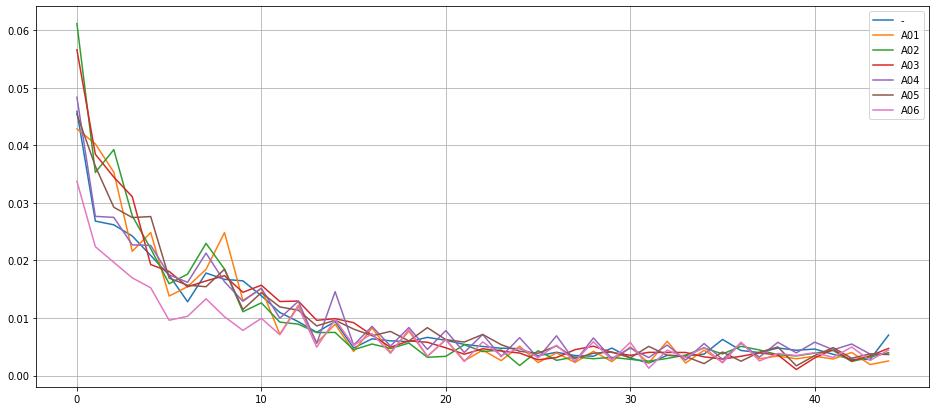

In [20]:
plt.figure(figsize=(16,7))

for alg in train_algs:
    
    feature_index = 6
    
    plt.plot(np.diff(np.nanmedian(train_alg[alg][:, feature_index::8], axis=0))[4:],label=alg)
    plt.legend()
    plt.grid()

ValueError: supplied range of [-inf, -4.470828115986923] is not finite

<Figure size 1152x504 with 0 Axes>

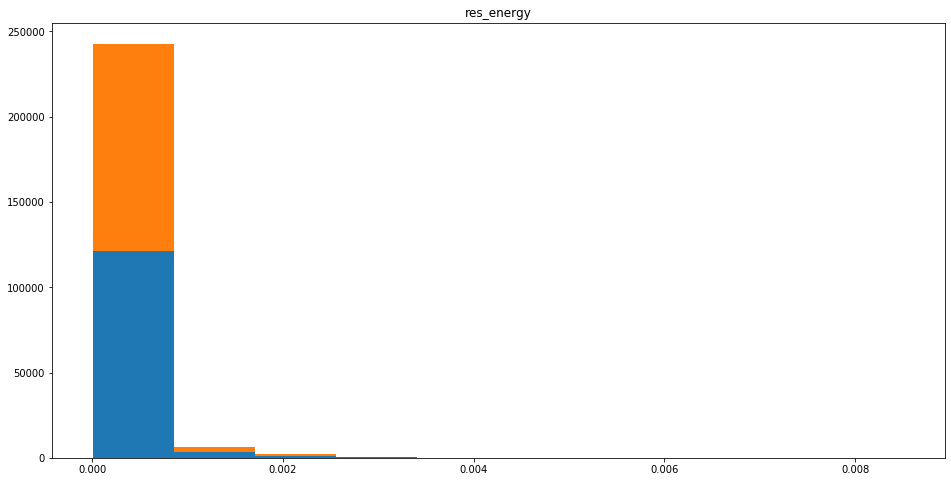

<Figure size 1152x504 with 0 Axes>

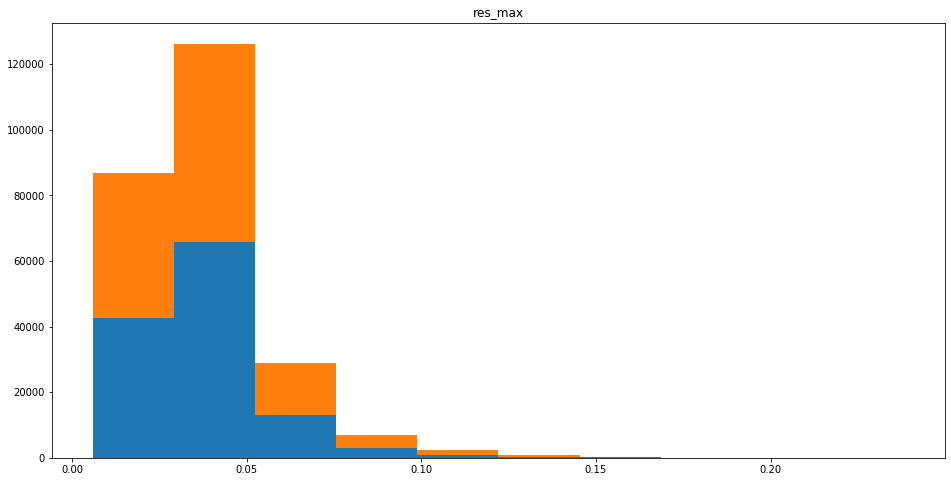

<Figure size 1152x504 with 0 Axes>

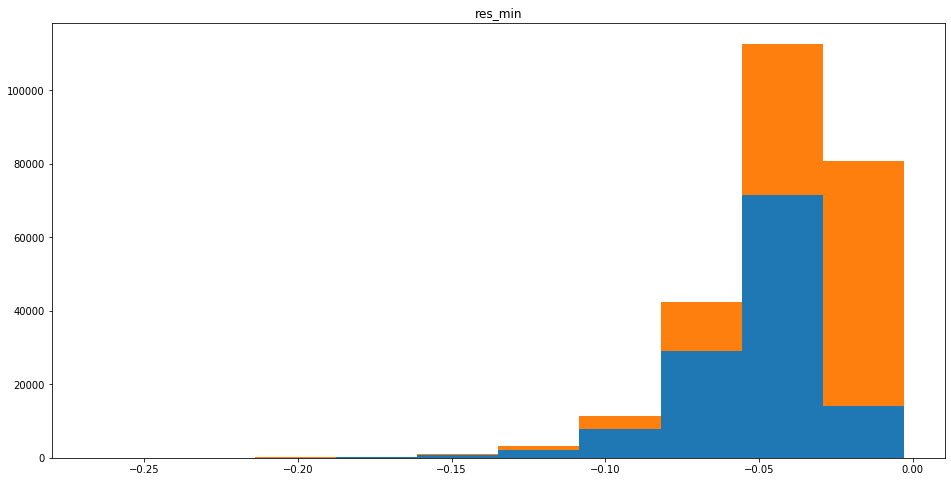

<Figure size 1152x504 with 0 Axes>

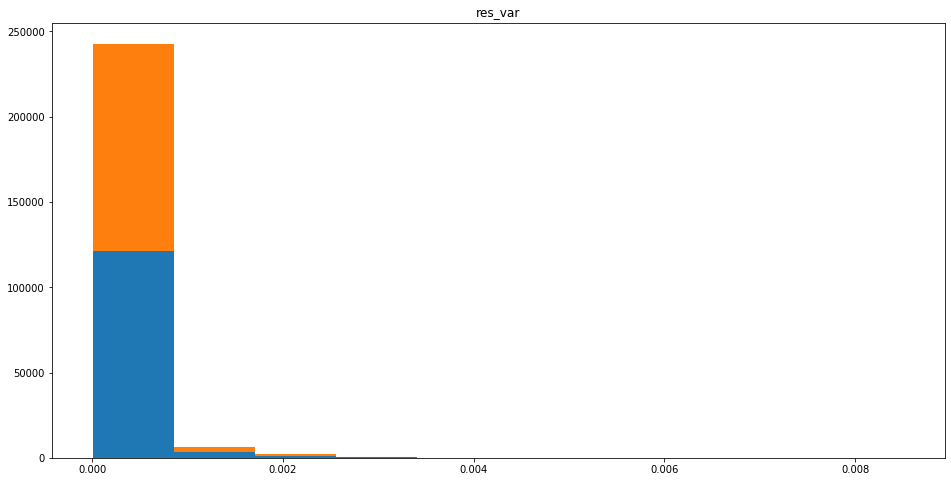

<Figure size 1152x504 with 0 Axes>

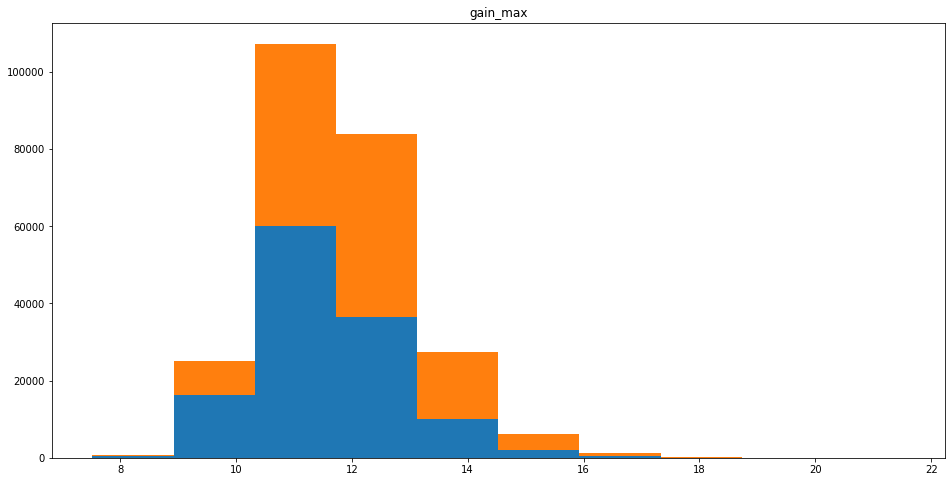

<Figure size 1152x504 with 0 Axes>

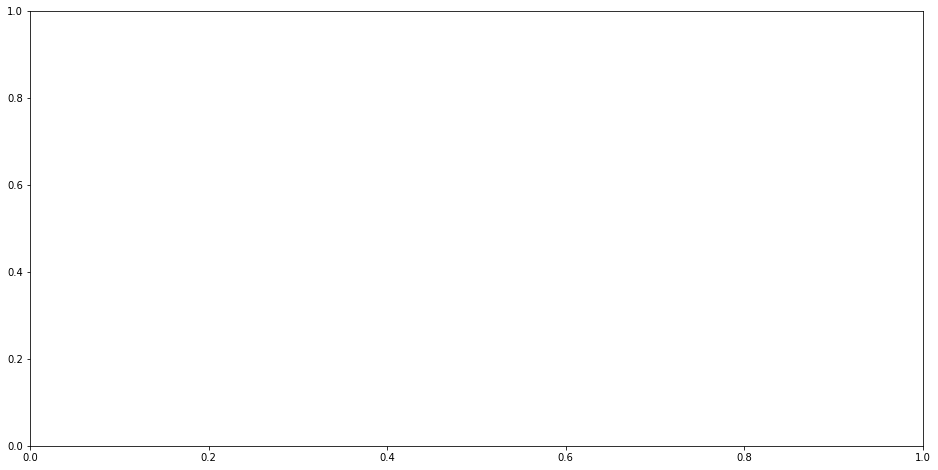

In [7]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.figure(figsize=(16,8))
    plt.hist([X_train_bonafide[:, feature_index::8].reshape(-1), X_train_spoof
                             [:, feature_index::8].reshape(-1)], stacked=True)
    plt.title(feature_list[i])


In [ ]:
X_train_bonafide[:, feature_index::8].shape

### Extract dev features

In [ ]:
X_dev_bonafide_list = []
X_dev_spoof_list = []

for l in lpc_lengths:
    dev_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/dev_LPC_' + str(l) +'.pkl')
    dev_features.drop('coeff', axis=1, inplace=True)
    dev_features.dropna(inplace=True)  
    
    dev_bonafide_features = dev_features[dev_features['label']=='bonafide']
    dev_spoof_features = dev_features[dev_features['label']=='spoof']
    
    if l==1:
        dev_spoof_features = dev_features[dev_features['label']=='spoof'].sample(n=dev_bonafide_features.shape[0])
        selected_files = dev_spoof_features['audio_filename']
    else:
        dev_spoof_features = dev_spoof_features[dev_spoof_features['audio_filename'].isin(selected_files)]
    
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_energy']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_var']).reshape((-1, 1)))
    
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_energy']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_var']).reshape((-1, 1)))
    
    if  if gain_log_scale == False:
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_max']).reshape((-1, 1)))
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_min']).reshape((-1, 1)))
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_mean']).reshape((-1, 1)))
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_var']).reshape((-1, 1)))

        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_max']).reshape((-1, 1)))
        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_min']).reshape((-1, 1)))
        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_mean']).reshape((-1, 1)))
        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_var']).reshape((-1, 1)))
    else:
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_max']).reshape((-1, 1))))
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_min']).reshape((-1, 1))))
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_mean']).reshape((-1, 1))))
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_var']).reshape((-1, 1))))

        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_max']).reshape((-1, 1))))
        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_min']).reshape((-1, 1))))
        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_mean']).reshape((-1, 1))))
        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_var']).reshape((-1, 1))))

In [ ]:
X_dev_bonafide = np.concatenate(X_dev_bonafide_list, axis=1)
X_dev_spoof = np.concatenate(X_dev_spoof_list, axis=1)
X_dev = np.concatenate((X_dev_bonafide, X_dev_spoof), axis=0)

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.plot(np.nanmedian(X_dev_bonafide[:, feature_index::8], axis=0), color='blue')
    plt.plot(np.nanmedian(X_dev_spoof[:, feature_index::8], axis=0), color='red')
    plt.title(feature_list[i])

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.figure(figsize=(16,8))
    plt.hist([X_dev_bonafide[:, feature_index::8].reshape(-1), X_dev_spoof
                             [:, feature_index::8].reshape(-1)], stacked=True)
    plt.title(feature_list[i])

### Extract eval features

In [ ]:
X_eval_bonafide_list = []
X_eval_spoof_list = []

for l in lpc_lengths:
    eval_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/eval_LPC_' + str(l) +'.pkl')
    #eval_features = eval_features[~eval_features['audio_filename'].isin(excluded_files)]
    eval_features.drop('coeff', axis=1, inplace=True)
    eval_features.dropna(inplace=True)

    eval_bonafide_features = eval_features[eval_features['label']=='bonafide']
    eval_spoof_features= eval_features[eval_features['label']=='spoof']
    
    if l==1:
        eval_spoof_features = eval_features[eval_features['label']=='spoof'].sample(n=eval_bonafide_features.shape[0])
        selected_files = eval_spoof_features['audio_filename']
    else:
        eval_spoof_features = eval_spoof_features[eval_spoof_features['audio_filename'].isin(selected_files)]
    
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_energy']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_var']).reshape((-1, 1)))
    


    X_eval_spoof_list.append(np.array(eval_spoof_features['res_energy']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['res_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['res_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['res_var']).reshape((-1, 1)))
    
    if gain_log_scale == False:
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_max']).reshape((-1, 1)))
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_min']).reshape((-1, 1)))
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_mean']).reshape((-1, 1)))
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_var']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_max']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_min']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_mean']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_var']).reshape((-1, 1)))
    else:
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_max']).reshape((-1, 1))))
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_min']).reshape((-1, 1))))
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_mean']).reshape((-1, 1))))
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_var']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_max']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_min']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_mean']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_var']).reshape((-1, 1))))

In [ ]:
X_eval_bonafide = np.concatenate(X_eval_bonafide_list, axis=1)
X_eval_spoof = np.concatenate(X_eval_spoof_list, axis=1)
X_eval = np.concatenate((X_eval_bonafide, X_eval_spoof), axis=0)

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.figure(figsize=(16,8))
    plt.hist([X_eval_bonafide[:, feature_index::8].reshape(-1), X_eval_spoof
                             [:, feature_index::8].reshape(-1)], stacked=True)
    plt.title(feature_list[i])


In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.plot(np.nanmedian(X_eval_bonafide[:, feature_index::8], axis=0), color='blue')
    plt.plot(np.nanmedian(X_eval_spoof[:, feature_index::8], axis=0), color='red')
    plt.title(feature_list[i])

## Check nan inf and max value

In [ ]:
print(np.all(np.isfinite(X_train)))
print(np.any(np.isnan(X_train)))
print(np.max(np.abs(X_train)))
print(np.finfo(np.float32).max)

In [ ]:
is_float = X_train.dtype.kind in 'fc'

from sklearn.utils.extmath import _safe_accumulator_op

np.isfinite(_safe_accumulator_op(np.sum, X_train))

In [ ]:
X_dev[X_dev >= np.finfo(np.float32).max] = np.finfo(np.float32).max
X_train[X_train >= np.finfo(np.float32).max] = np.finfo(np.float32).max
X_eval[X_eval >= np.finfo(np.float32).max] = np.finfo(np.float32).max

## Try normalization

In [ ]:
X_train_bonafide_norm = normalize_features(X_train_bonafide, max_lpc_order)
X_train_spoof_norm = normalize_features(X_train_spoof, max_lpc_order)


In [ ]:
plt.figure(figsize=(16, 8))
plt.imshow(X_train_bonafide_norm, aspect='auto')

In [ ]:
plt.figure(figsize=(16, 8))
plt.imshow(X_train_spoof_norm, aspect='auto')

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.plot(np.nanmedian(X_train_bonafide_norm[:, feature_index::8], axis=0), color='blue')
    plt.plot(np.nanmedian(X_train_spoof_norm[:, feature_index::8], axis=0), color='red')
    plt.title(feature_list[i])